In [12]:
!pip install pytorch-forecasting
!pip install torch torchvision torchaudio
!pip install optuna

Install and Import Libraries

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightning.pytorch import Trainer, LightningModule
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Load and Preprocess Data

In [14]:
train_file = "..\\Data\\Train\\trains1990s.csv"
df = pd.read_csv(train_file, parse_dates=['observation_date'])

df.columns = df.columns.str.replace('.', '_', regex=False)
df.rename(columns={'observation_date': 'Date', 'fred_PCEPI': 'Inflation'}, inplace=True)
df['time_idx'] = range(len(df))  # Create numerical time index

# Normalize Inflation Data using StandardScaler
scaler = StandardScaler()
df['Inflation'] = scaler.fit_transform(df[['Inflation']])

# Split Data into Train & Validation (80% train, 20% validation)
split_idx = int(len(df) * 0.8)
train_df, val_df = df.iloc[:split_idx], df.iloc[split_idx:]

<ipython-input-14-ed0756ec5c94>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=['observation_date'])


Function to Create Sequences

In [15]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i: i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

sequence_length = 12  # Use past 12 months to predict next step
X_train, y_train = create_sequences(train_df["Inflation"].values, sequence_length)
X_val, y_val = create_sequences(val_df["Inflation"].values, sequence_length)

# Convert to Torch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

# DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

Define RNN Model

In [16]:
class RNNModel(LightningModule):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, learning_rate=0.001):
        super(RNNModel, self).__init__()
        self.save_hyperparameters()  # Saves hyperparameters for logging
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Hyperparameter Tuning with Optuna

In [17]:
def objective(trial):
    try:
        print(f"Trial {trial.number} starting...")

        # Suggest hyperparameters
        hidden_size = trial.suggest_int("hidden_size", 32, 256)
        num_layers = trial.suggest_int("num_layers", 1, 4)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

        # Define model
        model = RNNModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1, learning_rate=learning_rate)

        # Define early stopping
        early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

        trainer = Trainer(
            max_epochs=50,
            accelerator="auto",
            callbacks=[early_stopping],
            enable_checkpointing=False,
            log_every_n_steps=10
        )

        # Train model
        trainer.fit(model, train_loader, val_loader)

        # Get validation loss
        best_val_loss = trainer.callback_metrics.get("val_loss")
        if best_val_loss is None:
            return float("inf")

        return best_val_loss.item()

    except Exception as e:
        print(f"Trial failed due to {e}")
        return float("inf")

# Run Optuna Tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# Get Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-03-10 20:30:59,135] A new study created in memory with name: no-name-9ba80643-6bea-4230-950e-71b979aca881
<ipython-input-17-3d91303c6cfb>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Trial 0 starting...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 270 K  | train
1 | fc      | Linear  | 197    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
270 K     Trainable params
0         Non-trainable params
270 K     Total params
1.083     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 270 K  | train
1 | fc      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 20:31:24,736] Trial 0 finished with value: 0.027664246037602425 and parameters: {'hidden_size': 196, 'num_layers': 4, 'learning_rate': 4.1019028374882815e-05}. Best is trial 0 with value: 0.027664246037602425.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Trial 1 starting...


INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 42.2 K | train
1 | fc      | Linear  | 205    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 42.2 K | train
1 | fc      | Linear  | 205    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 20:31:55,567] Trial 1 finished with value: 0.003599317744374275 and parameters: {'hidden_size': 204, 'num_layers': 1, 'learning_rate': 0.0013108378000050464}. Best is trial 1 with value: 0.003599317744374275.


Trial 2 starting...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 12.9 K | train
1 | fc      | Linear  | 113    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 12.9 K | train
1 | fc      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 20:32:07,811] Trial 2 finished with value: 0.00531826401129365 and parameters: {'hidden_size': 112, 'num_layers': 1, 'learning_rate': 0.0019121642485250378}. Best is trial 1 with value: 0.003599317744374275.


Trial 3 starting...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 22.6 K | train
1 | fc      | Linear  | 87     | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 22.6 K | train
1 | fc      | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 20:32:33,456] Trial 3 finished with value: 0.030997704714536667 and parameters: {'hidden_size': 86, 'num_layers': 2, 'learning_rate': 4.329844006171886e-05}. Best is trial 1 with value: 0.003599317744374275.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 4.5 K  | train
1 | fc      | Linear  | 39     | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
3         Modules in train

Trial 4 starting...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-03-10 20:32:43,538] Trial 4 finished with value: 0.08686429262161255 and parameters: {'hidden_size': 38, 'num_layers': 2, 'learning_rate': 0.00015675452079171948}. Best is trial 1 with value: 0.003599317744374275.


Best Hyperparameters: {'hidden_size': 204, 'num_layers': 1, 'learning_rate': 0.0013108378000050464}


Train Final RNN Model

In [18]:
best_model = RNNModel(
    input_size=1,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    output_size=1,
    learning_rate=best_params["learning_rate"]
)

trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, mode="min"),
        ModelCheckpoint(dirpath="rnn_best_model", save_top_k=1, monitor="val_loss", mode="min")
    ],
    log_every_n_steps=10
)

trainer.fit(best_model, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/rnn_best_model exists and is not empty.
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 42.2 K | train
1 | fc      | Linear  | 205    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
42.4 K    Trainable params
0         Non-trainable params
42.4 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

 Evaluate Model & Make Predictions

In [19]:
best_model.eval()
predictions = []

with torch.no_grad():
    for seq in X_val_tensor:
        seq = seq.view(1, sequence_length, 1)  # Batch size 1
        pred = best_model(seq).cpu().numpy().flatten()
        predictions.append(pred)

# Convert predictions to NumPy
pred_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Get actual values from val_df
actual_values = scaler.inverse_transform(val_df["Inflation"].values[sequence_length:].reshape(-1, 1))

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Date": val_df["Date"].iloc[sequence_length:],
    "Actual": actual_values.flatten(),
    "Predicted": pred_values.flatten()
})

# Compute RMSE & R²
rnn_rmse = np.sqrt(mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"]))
rnn_r2 = r2_score(comparison_df["Actual"], comparison_df["Predicted"])

print(f"RNN Model RMSE: {rnn_rmse:.4f}")
print(f"RNN Model R² Score: {rnn_r2:.4f}")

RNN Model RMSE: 0.8805
RNN Model R² Score: 0.8729


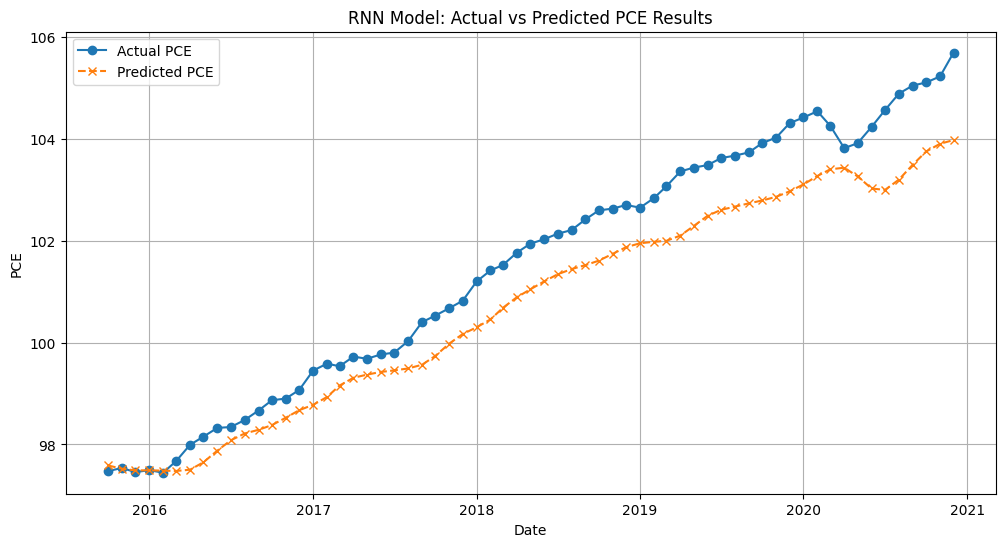

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Date"], comparison_df["Actual"], label="Actual PCE", marker="o")
plt.plot(comparison_df["Date"], comparison_df["Predicted"], label="Predicted PCE", linestyle="--", marker="x")
plt.title("RNN Model: Actual vs Predicted PCE Results")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.legend()
plt.grid()
plt.show()
